In [1]:
# For Sam

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

loading the dataset

In [3]:
dataset = pd.read_csv("Train.csv")

Checking it out

In [4]:
dataset.head(2)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993


In [5]:
riders = pd.read_csv('Riders.csv')
riders.head(2)

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176


In [46]:
xdata = dataset.drop(columns=['Time from Pickup to Arrival', 'User Id', 'Order No', 'Arrival at Destination - Time']) 
X = xdata.copy() # I want to run this column everytime I want to restart after changes
X = X.merge(riders, how='left', on=['Rider Id'])
X.drop(columns=['Rider Id'], inplace=True)

X.head(2)

,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,...,Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,...,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549
1,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,...,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69


In [47]:
y = dataset['Time from Pickup to Arrival'] # The target

We Split

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now things are about to get ugly

In [49]:
### START FUNCTION
def cleaner(input_df, nullthreshold=0.9, correlation_thresh=0.95, day_of_month_cols=[], day_of_week_cols=[]):
    input_dfc = input_df.copy()
    

    #########################################################################################
    # The Code below drops columns that have null values exceeding threshold and Columns that have ONLY one value
    for col in input_df.columns:
        if (sum(input_df[col].isnull())/len(input_df[col]) > nullthreshold) or (len(input_df[col].unique()) == 1):
            input_dfc.drop(columns=[col], inplace=True) 
            
    #########################################################################################

    #########################################################################################
    #This code converts time given by am and pm into seconds then applies cosine and sine
    def time_to_seconds(input_df):
        input_dfc = input_df.copy()

        from datetime import datetime

        for time_col in [col for col in input_df.columns if 'Time' in [col[-4:]]]:

            input_dfc[time_col + '_sin(seconds)'] = \
            input_df[time_col].apply(lambda time: np.sin(
                (datetime.strptime(time, '%I:%M:%S %p') - datetime(1900,1,1)).total_seconds() \
                * (2.*np.pi/86400) )) # there are 86400 seconds in a day

            input_dfc[time_col + '_cos(seconds)'] = \
            input_df[time_col].apply(lambda time: np.cos(
                (datetime.strptime(time, '%I:%M:%S %p') - datetime(1900,1,1)).total_seconds() \
                * (2.*np.pi/86400) ))

            input_dfc.drop(columns=[time_col], inplace=True)

        return input_dfc

    input_dfc2 = time_to_seconds(input_dfc)
    #########################################################################################
    
    #########################################################################################
    # This code encodes ['Platform Type', 'Personal or Business']
    
    def one_encoder(input_df, columns):
    
        return pd.get_dummies(input_df, drop_first=True, columns=columns, dtype=float)

    
    input_dfc2 = one_encoder(input_dfc2, ['Platform Type', 'Personal or Business'])
    #########################################################################################
    
    #########################################################################################
    # This code will remove one of a pair of variables that are 95% correlated
    def correlation_drop(df, thresh):
        while True:
            corr_matrix = df.corr(method = "spearman").abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
            to_drop = [column for column in upper.columns if any(upper[column] > thresh)]
            if len(to_drop) == 0:
                break
            else:
                df = df.drop(to_drop, axis = 1)
            
        return df
    
    input_dfc2 = correlation_drop(input_dfc2, correlation_thresh)
    #########################################################################################

    print(f"Total of {len([x for x in input_df.columns if x not in input_dfc2])} original columns dropped \n")  
    print(f"Total of {len([x for x in input_dfc2.columns if x not in input_df])} new CLEAN columns formed \n")
    print(f"Dataframe now has {len(input_dfc2.columns)} from {len(input_df.columns)} input columns")
    #print([x for x in input_df.columns if x not in input_dfc2])

    return input_dfc2

### END FUNCTION

In [50]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPRegressor
# from sklearn.pipeline import Pipeline

# # Construct the pipeline with a standard scaler and a small neural network
# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('nn', MLPRegressor(hidden_layer_sizes=(5,), max_iter=1000)))
# model = Pipeline(estimators)

# # To begin, let's use only these two features to predict 'cnt' (bicycle count)
# features = ['mnth','hr']
# X = df[features].values
# y = df.cnt

# # We'll use 5-fold cross validation. That is, a random 80% of the data will be used
# # to train the model, and the prediction score will be computed on the remaining 20%.
# # This process is repeated five times such that the training sets in each "fold"
# # are mutually orthogonal.
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=5)

# results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
# print 'CV Scoring Result: mean=',np.mean(results),'std=',np.std(results)

 Actually for the first model, I will drop the 'Arrival at Destination - Time' column, I believe it is directly linked to the predicted y
 As y is the difference between the 'Arrival at Destination - Time' and 'Pick up time'

Now we apply our ultimate cleaner

In [51]:
day_of_month_cols = [x for x in X.columns if x[-5:] == 'Month']
day_of_week_cols = [x for x in X.columns if x[-(len('(Mo = 1)')):] == '(Mo = 1)']
X_train = cleaner(X_train, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols)


Total of 16 original columns dropped 

Total of 6 new CLEAN columns formed 

Dataframe now has 18 from 28 input columns


In [52]:
X_test = cleaner(X_test, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols)

Total of 16 original columns dropped 

Total of 6 new CLEAN columns formed 

Dataframe now has 18 from 28 input columns


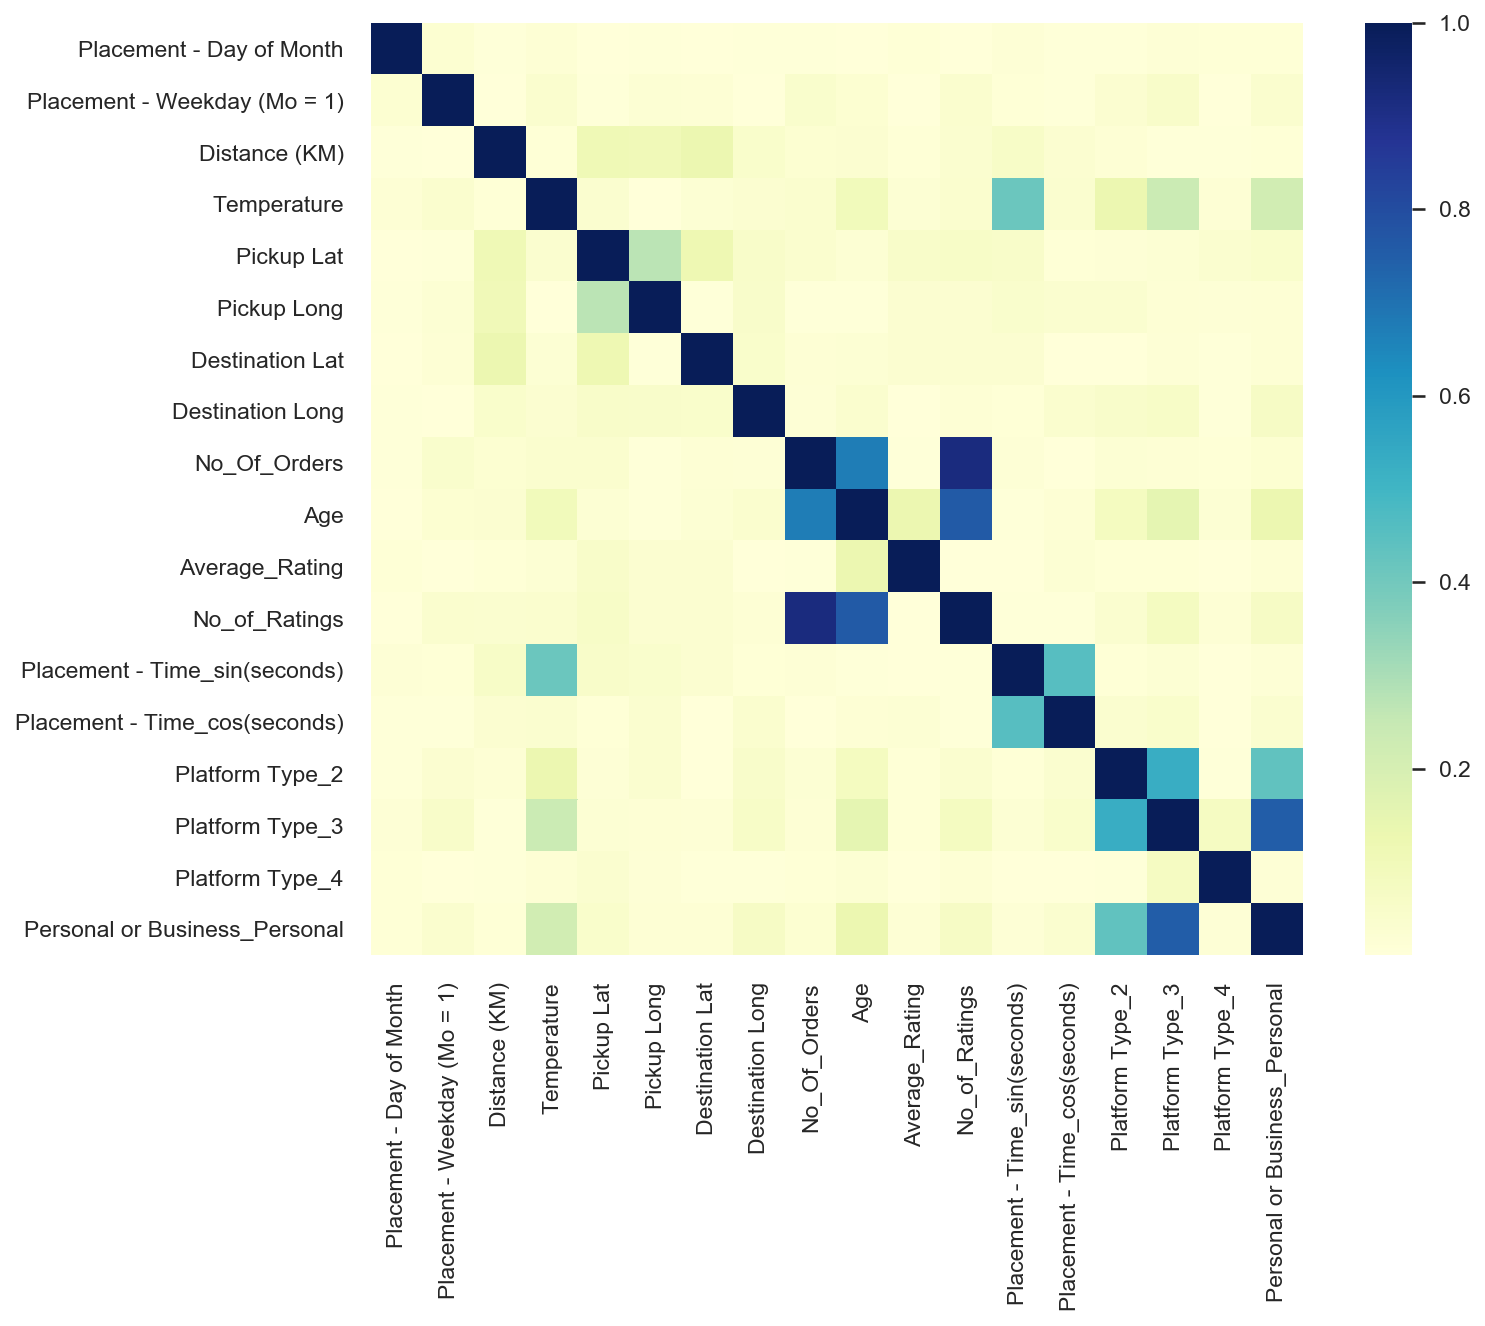

In [53]:
corr_matrix = X_train.corr(method = "spearman").abs()
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

plt.show()

In [54]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

[]

In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16960 entries, 18434 to 9043
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Placement - Day of Month       16960 non-null  int64  
 1   Placement - Weekday (Mo = 1)   16960 non-null  int64  
 2   Distance (KM)                  16960 non-null  int64  
 3   Temperature                    13464 non-null  float64
 4   Pickup Lat                     16960 non-null  float64
 5   Pickup Long                    16960 non-null  float64
 6   Destination Lat                16960 non-null  float64
 7   Destination Long               16960 non-null  float64
 8   No_Of_Orders                   16960 non-null  int64  
 9   Age                            16960 non-null  int64  
 10  Average_Rating                 16960 non-null  float64
 11  No_of_Ratings                  16960 non-null  int64  
 12  Placement - Time_sin(seconds)  16960 non-nu

Our data is ready

We will standardize the columns which have a max absolute value that is greater than 1

In [35]:
cols_to_standard = [x for x in X_train.columns if max(X_train[x].apply(abs)) > 1]

In [37]:
cols_to_standard

['Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Distance (KM)',
 'Temperature',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'No_Of_Orders',
 'Age',
 'Average_Rating',
 'No_of_Ratings']

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16960 entries, 17620 to 12584
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Placement - Day of Month       16960 non-null  int64  
 1   Placement - Weekday (Mo = 1)   16960 non-null  int64  
 2   Distance (KM)                  16960 non-null  int64  
 3   Temperature                    13474 non-null  float64
 4   Pickup Lat                     16960 non-null  float64
 5   Pickup Long                    16960 non-null  float64
 6   Destination Lat                16960 non-null  float64
 7   Destination Long               16960 non-null  float64
 8   No_Of_Orders                   16960 non-null  int64  
 9   Age                            16960 non-null  int64  
 10  Average_Rating                 16960 non-null  float64
 11  No_of_Ratings                  16960 non-null  int64  
 12  Placement - Time_sin(seconds)  16960 non-n

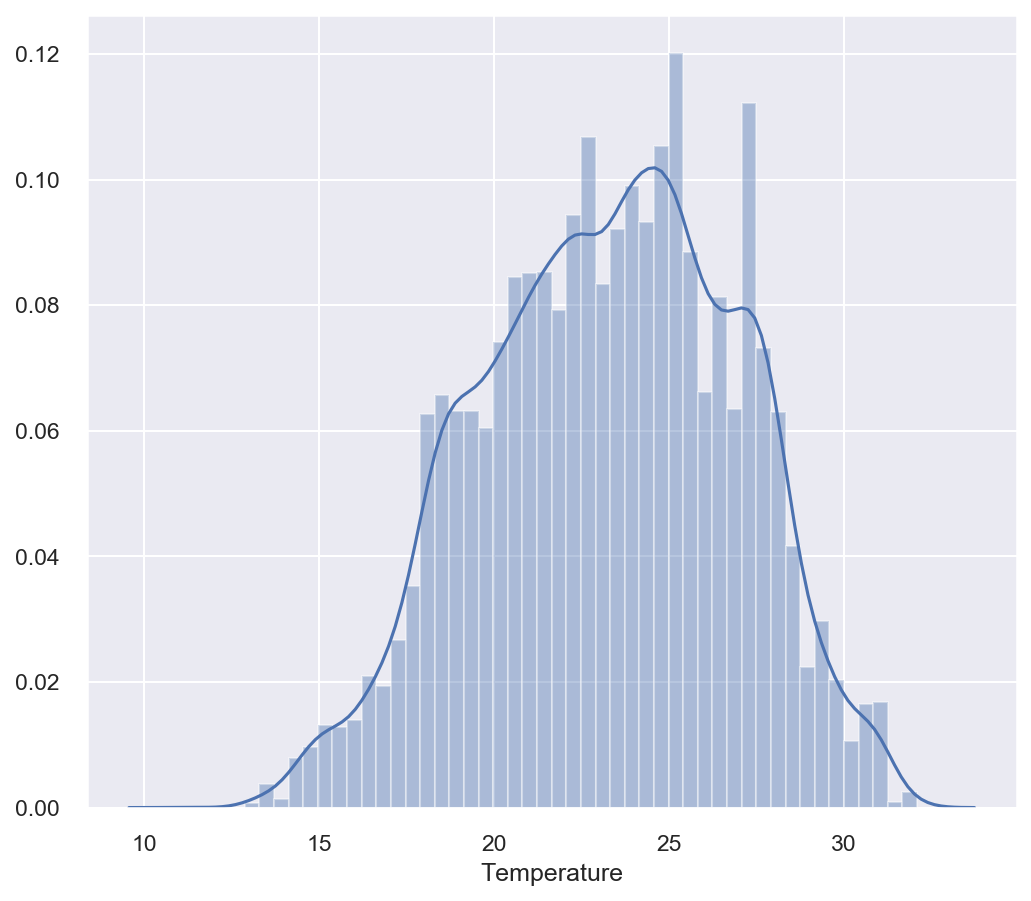

In [29]:
sns.distplot(X['Temperature'])
plt.show()

In [30]:
X['Temperature'].fillna(X['Temperature'].median(), inplace=True)

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Vehicle Type                               21201 non-null  object 
 1   Platform Type                              21201 non-null  int64  
 2   Personal or Business                       21201 non-null  object 
 3   Placement - Day of Month                   21201 non-null  int64  
 4   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 5   Placement - Time                           21201 non-null  object 
 6   Confirmation - Day of Month                21201 non-null  int64  
 7   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 8   Confirmation - Time                        21201 non-null  object 
 9   Arrival at Pickup - Day of Month           21201 non-null  int64  
 10  Arrival at Pickup - We

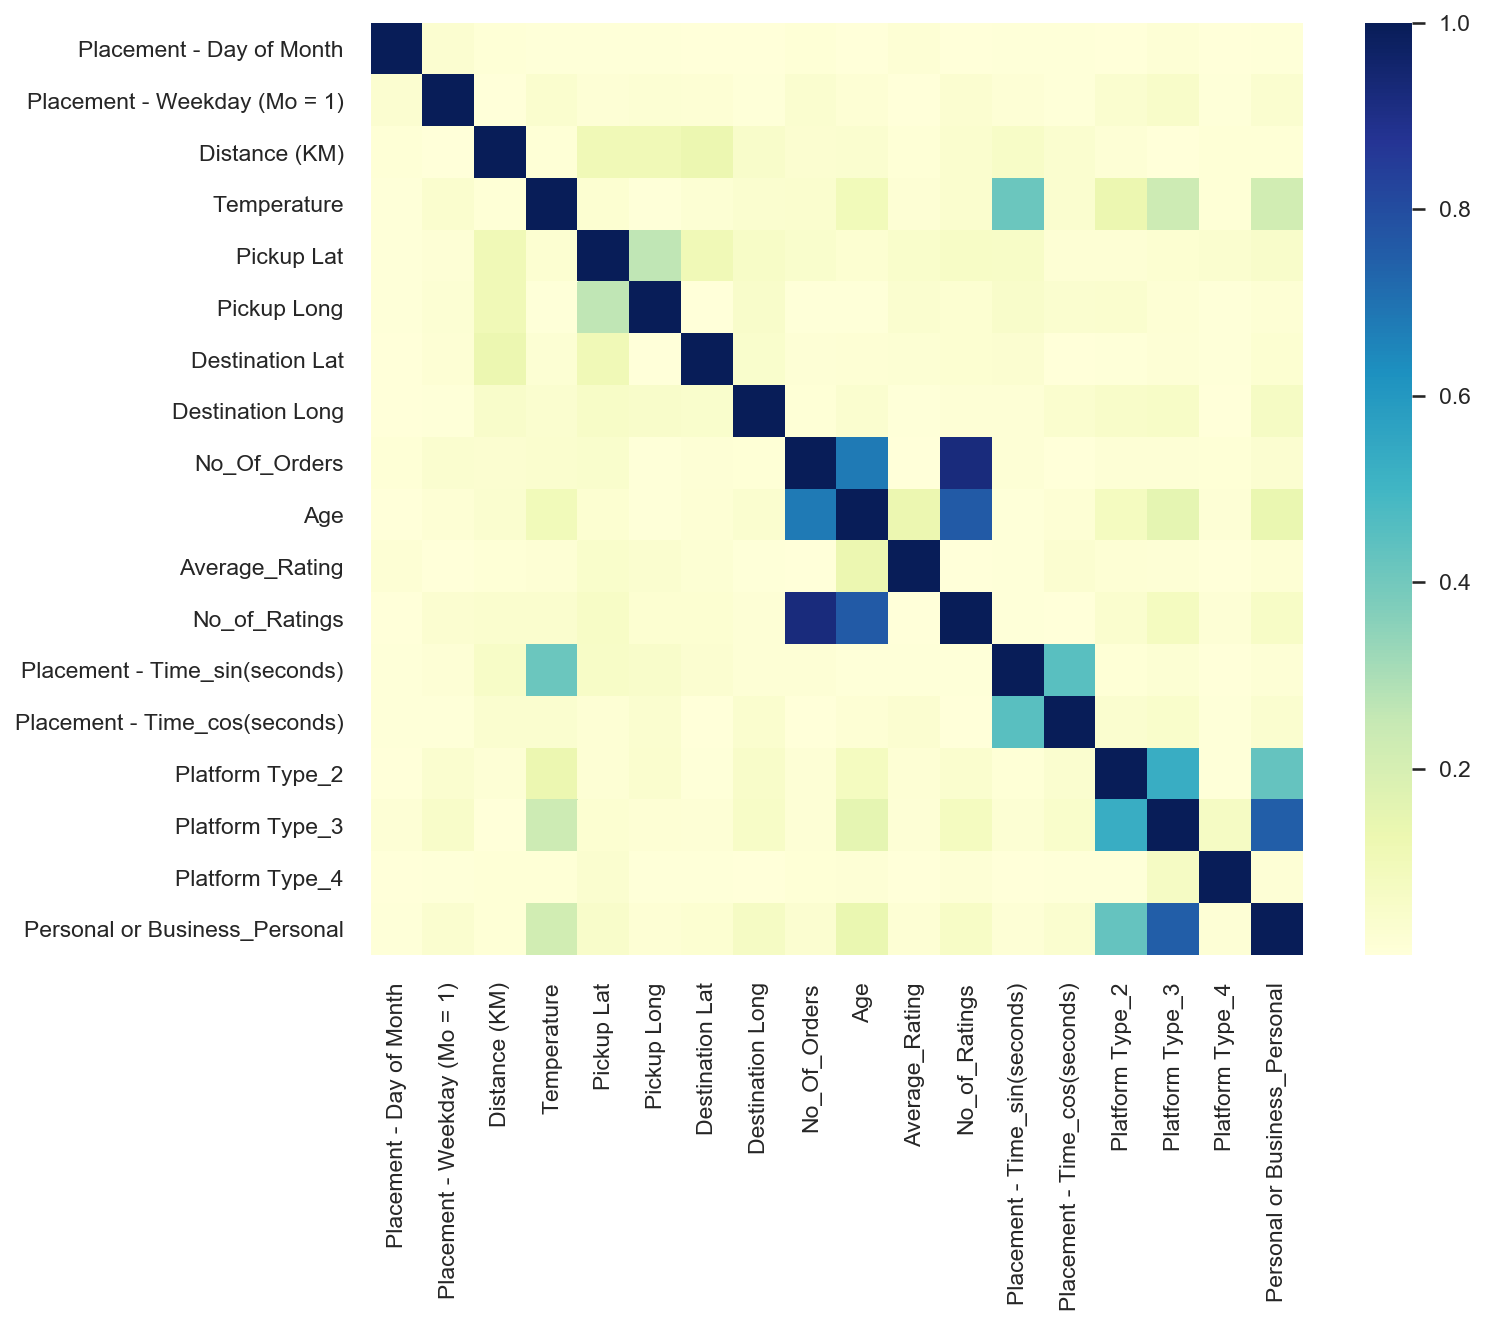

In [19]:
corr_matrix = X_train.corr(method = "spearman").abs()
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

plt.show()

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [73]:
models = [LinearRegression()]
polinomial_features = PolynomialFeatures(2)


for model in models:
    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_to_standard)])
    
    steps = [('imputer', SimpleImputer(strategy='mean')), ('polf', polinomial_features), 
          ('Scaler', StandardScaler()),
          ('model', model)]
    
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    print(model)
    print("model score: %.3f" % pipe.score(X_test, y_test))
    print('\n')
    

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
model score: 0.364




In [ ]:
len(X_train['Age'])

In [57]:
r2_score(y_test, y_pred)

NameError: name 'r2_score' is not defined

In [ ]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[('impute', SimpleImputer()),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
riders.head()

In [ ]:
X.info()

In [ ]:
sample = pd.read_csv('SampleSubmission.csv')

In [ ]:
sample

In [31]:
finaltest = pd.read_csv("Test.csv")

In [32]:
finaltest.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [30]:
finaltest.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id'],
      dtype='object')

In [ ]:
len(dataset['Order No'].unique())